In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')
import multiprocessing
print("num of cpus:", multiprocessing.cpu_count())


num of cpus: 128


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#folder_path = '/content/drive/MyDrive/TDS_data_15000'
folder_path = './15K files/'
#Load and preprocess the data
def load_data(folder_path):
  data = {}
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      if os.path.isfile(file_path):
          with open(file_path, 'r') as file:
              df1 = pd.read_csv(file_path, header=None, names=['des_flux', 'detrap_en', 'def_conc'], index_col=None, squeeze = True)
              data[filename] = df1
    
              num_datapts = len(df1["des_flux"])
  # Combine all the data into a single dataframe
  df = pd.concat(data.values())

  return df, num_datapts

df, num_datapts = load_data(folder_path)

des_flux=df['des_flux']
des_flux=des_flux.tolist()
num_files=int(len(des_flux)/num_datapts) 
des_flux=np.reshape(des_flux, [num_files, num_datapts])
    # This assumes that all spectra in the dataset/folder have the same
    # amount of datapoints
print(type(des_flux[0]), des_flux.shape)

detrap_en=df['detrap_en']
detrap_en=detrap_en.dropna()
detrap_en=detrap_en.tolist()
num_files=int(len(detrap_en)/4)
detrap_en=np.reshape(detrap_en, [num_files, 4])


def_conc=df['def_conc']
def_conc=def_conc.dropna()
def_conc=def_conc.tolist()
num_files=int(len(def_conc)/4)
def_conc=np.reshape(def_conc, [num_files, 4])


def_param = np.concatenate([detrap_en, def_conc], axis=1)
def_param = np.log10(def_param) # transforming the targets
print(def_param.shape)

<class 'numpy.ndarray'> (15000, 301)
(15000, 8)


##### Manually adding features

Note that the features table only takes into account the global maximum and not any local max.


In [3]:
# Peak information
# Peak heights, position, and full width at half max
from scipy.signal import peak_widths, find_peaks, peak_prominences
from scipy.optimize import curve_fit
from sklearn.metrics import auc


peak_heights = []
fwhm = []
peak_positions = []
area_under_curves = []
stdev = []
peak_prom = []

for i in des_flux:
    peaks, _ = find_peaks(i)
    peak_pos = np.argmax(i)
    peak_height = np.max(i)
    peak_width, _, _, _ = peak_widths(i, [peak_pos], rel_height=0.5) 
        #taking only the first output (widths)
    prominence = np.max(peak_prominences(i, peaks)[0])
    peak_heights.append(peak_height)
    peak_prom.append(prominence)
    fwhm.append(peak_width[0])
    peak_positions.append(peak_pos)
# Area under curve
# Calculated using the trapezoidal method
    area_under_curve = auc(range(0,len(i)), i)
    area_under_curves.append(area_under_curve)
#STDEV
    spectra_std = np.std(i)
    stdev.append(spectra_std)


In [4]:
# PCA Components based on normalized spectra

# Standardizing and applying PCA using a pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))])

scaled_des_flux = pca_pipe.fit_transform(des_flux)
result_pca = pca_pipe.fit_transform(scaled_des_flux)


# Formatting them into columns in a df
pca_col = ['PCA Component {}'.format(i+1) for i in range(result_pca.shape[1])]
pca_df = pd.DataFrame(data=result_pca, columns=pca_col)

display(pca_df)

,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5
0,2.399713,-0.099691,1.043877,0.246222,0.566587
1,0.981449,-1.023512,1.474494,-0.164535,-0.482770
2,0.639782,0.615698,0.083897,-0.258922,-0.369535
3,0.829157,0.559444,-0.258759,-0.361560,0.416992
4,-0.027969,0.382054,0.181193,-0.579052,-0.327126
...,...,...,...,...,...
14995,0.512062,-0.229937,1.031827,-1.135168,0.779304
14996,-0.795610,1.118923,-0.723470,0.235511,-1.985075
14997,-1.387056,0.743302,1.960027,2.773962,-0.735943
14998,-1.160667,2.359334,5.311600,9.574801,8.489554


In [5]:
### Making the features matrix 
features_matrix = pd.DataFrame()
features_matrix['peak_heights'] = peak_heights 
features_matrix['peak_pos'] = peak_positions
features_matrix['fwhm'] = fwhm
features_matrix['peak prominences'] = peak_prom
features_matrix['auc'] = area_under_curves
features_matrix['std'] = stdev
features_matrix = pd.concat([features_matrix, pca_df],axis=1)
display(features_matrix)

,peak_heights,peak_pos,fwhm,peak prominences,auc,std,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5
0,1.104600e+19,139,62.925853,1.104600e+19,7.168618e+20,3.670862e+18,2.399713,-0.099691,1.043877,0.246222,0.566587
1,8.952698e+18,108,76.863979,8.952698e+18,6.980819e+20,3.100856e+18,0.981449,-1.023512,1.474494,-0.164535,-0.482770
2,6.449705e+18,135,118.976213,6.449705e+18,6.585460e+20,2.208307e+18,0.639782,0.615698,0.083897,-0.258922,-0.369535
3,6.255561e+18,150,99.830005,6.255561e+18,5.768126e+20,2.134721e+18,0.829157,0.559444,-0.258759,-0.361560,0.416992
4,3.924261e+18,109,155.580504,3.924261e+18,5.837127e+20,1.634831e+18,-0.027969,0.382054,0.181193,-0.579052,-0.327126
...,...,...,...,...,...,...,...,...,...,...,...
14995,5.871478e+18,121,70.829252,5.871478e+18,4.089573e+20,1.928194e+18,0.512062,-0.229937,1.031827,-1.135168,0.779304
14996,8.661125e+18,207,75.580094,8.661125e+18,8.404429e+20,2.822632e+18,-0.795610,1.118923,-0.723470,0.235511,-1.985075
14997,7.093851e+18,95,43.338462,7.093565e+18,9.985840e+20,2.359050e+18,-1.387056,0.743302,1.960027,2.773962,-0.735943
14998,7.871170e+18,242,122.573237,7.844419e+18,9.833929e+20,2.465215e+18,-1.160667,2.359334,5.311600,9.574801,8.489554


##### Gaussian Fitting

By Gaussian peak fitting to two peaks (the two most prominent spectroscopic peaks), similar to https://www.mdpi.com/1996-1944/13/23/5500, we can avoid generalizing to the global max. 

*The following curve fitting does not work, unfortunately. Please skip this section.* 

The fitted peaks would likely be its own training data set, since the fitted data will be similar to the raw data in format.

In [65]:
# Defining the gaussian function  
from scipy.optimize import curve_fit

def guass_params(y):
    # peak 1
    # parameters to calculate the gaussian
    x = np.arange(len(y))
    center = np.argmax(y)
    y_peak1 = y[center - 60:center + 60]
    stdev = np.std(y_peak1)
    amp = max(y) - min(y)

    indices, peak_dict = find_peaks(y, height=(None, None))
    heights = peak_dict['peak_heights']

    if len(indices) < 2:
        return x, amp, center, stdev, 0, 0, 0  # returns zeroes if there is no 2nd peak found
    # peak 2
    sorted_peak_indices = np.argsort(peak_dict['peak_heights'])
    center2 = indices[sorted_peak_indices[-2]]
    y_peak2 = y[center2 - 60:center2 + 60]
    stdev2 = np.std(y_peak2)
    amp2 = heights[sorted_peak_indices[-2]] - min(y)
    
    return x, amp, center, stdev, amp2, center2, stdev2

def gauss2(x, amp, center, stdev, amp2, center2, stdev2):
    '''
    Function for gaussian function to be used in Scipy.curve_fit.
    Calculates fitting for overlapping peaks (the highest peak and 
    the second highest peak) by taking the sum of both gaussians.
    '''
    if amp2 == 0 and center2 == 0 and stdev2 == 0:
        return amp * np.exp(-((x - center) ** 2) / (2 * stdev ** 2))
    
    return amp * np.exp(-((x - center) ** 2) / (2 * stdev ** 2))  + amp2 * np.exp(-((x - center2) ** 2) / (2 * stdev2 ** 2))

def gauss_fit_curve(y, popt):
    x = np.arange(len(y))
    amp_opt, center_opt, stdev_opt, amp2_opt, center2_opt, stdev2_opt = popt
    y_fit = gauss2(x, amp_opt, center_opt, stdev_opt, amp2_opt, center2_opt, stdev2_opt)
    return y_fit.tolist()




/home/bbragado/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/bbragado/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bbragado/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/bbragado/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


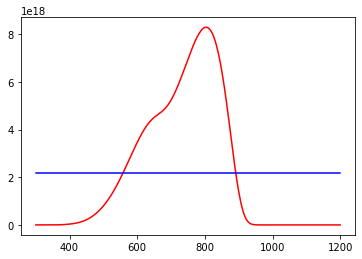

In [75]:
import matplotlib.pyplot as plt
y_fit = [] # storing the fitted data to use as an option for training data 
for i in des_flux:
    x, amp, center, stdev, amp2, center2, stdev2 = guass_params(i)
    temps = np.linspace(300,1200,301)
    popt, _ = curve_fit(gauss2, temps, i,p0=((4.0E18, 600, 1.5E18, 1E18, 900, 2.0E18))) # added random guesses to avoid 
    
    fitted = gauss_fit_curve(i,popt)
    y_fit.append(fitted)
plt.plot(temps, des_flux[6], 'r',label='Training Data') 
plt.plot(temps, y_fit[6], 'b',label='Fitted Curve')

# Produces curves that are straight lines :(

### Raw 0.3K/s, 15K dataset (Smoothed)

In [6]:
### Preparing the raw data
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


# Split the data into train and test sets
X_train, X_test= train_test_split(des_flux, test_size=0.1, random_state=42)
y_train_raw, y_test_raw = train_test_split(def_param, test_size=0.1, random_state=42)

# Normalize the data using StandardScaler 
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_norm = scaler.fit_transform(np.array(X_train).reshape(-1, num_datapts)) # Change lists into array
X_test_norm = scaler.transform(np.array(X_test).reshape(-1, num_datapts))

X_train_transform_raw = np.reshape(X_train_norm, (X_train_norm.shape[0], -1))
X_test_transform_raw = np.reshape(X_test_norm, (X_test_norm.shape[0], -1))

print(X_train_transform_raw.shape)
print(X_test_transform_raw.shape)



(13500, 301)
(1500, 301)


##### Hyperparameter search

Instead of using sklearn's hyperparameter tuning, we can perform hyperparameter optimization using based on the Bayes Theorem. Using the `hyperopt` package for hyperparameter optimization, comparable loss scores and better performance time compared to `GridSearchCV` has been achieved:
https://doi.org/10.11989/JEST.1674-862X.80904120
http://jmlr.org/proceedings/papers/v28/bergstra13.html

Documentation: http://hyperopt.github.io/hyperopt/

Parameter searching in `hyperopt` has a high level of customization. For example, defining the parameter grid can be done using two methods:
- `hp.choice`: Analogous to RandomizedSearchCV from sk-learn, randomly selects from a search space. 
- `hp.randint`: Analogous to GridSearchCV, iteratively and exhaustively searches within a range. 

In [7]:
#pip install hyperopt

In [7]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error

# Function to be optimized (check the hyperopt doc)
def objective(params):
    rfr = RandomForestRegressor(**params,random_state=42)
    scores = cross_val_score(rfr, X_train_transform_raw, y_train_raw, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()

    return mse

# Define param grid
space = {
    'n_estimators': hp.randint('n_estimators', 100, 201),
    'max_depth': hp.randint('max_depth', 1, 15),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
    'max_features': hp.choice('max_features', ["sqrt", "log2"])}

In [9]:
%%time
# Bayesian Optimization using the TPE algorithm `tpe` 
# TPE is sequential-based and balances "explore vs exploit" when 
# searching for hyperparameters: 

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

# best hyperparameters and best score
best_params = space_eval(space, best)
best_score = min(trials.losses())

print("Best Parameters:", best_params)
print("Best Score:", best_score)

100%|██████████| 100/100 [1:29:51<00:00, 53.92s/trial, best loss: 0.053124339306741444]
Best Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 188}
Best Score: 0.053124339306741444
CPU times: user 1h 29min 22s, sys: 2.43 s, total: 1h 29min 25s
Wall time: 1h 29min 51s


In [9]:
### Non-transformed trial:
# 100%|██████████| 100/100 [47:14<00:00, 28.35s/trial, best loss: 0.003159586913488544]
# Best Parameters: {'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 267}
# Best Score: 0.003159586913488544
# CPU times: user 47min 4s, sys: 2.93 s, total: 47min 7s
# Wall time: 47min 15s

# Performing a log transformation on the target variables increases loss error by a factor of 10

In [8]:
### Predicting Parameters

# Saving the best_params without having to rerun the search (most recent run)
best_params = {
    'n_estimators': 188,
    'max_depth': 13,
    'min_samples_leaf': 4,
    'max_features': 'sqrt'}

rfr_best_raw = RandomForestRegressor(**best_params, random_state=42)
rfr_best_raw.fit(X_train_transform_raw, y_train_raw)

y_pred_raw = rfr_best_raw.predict(X_test_transform_raw)

mse = mean_squared_error(y_test_raw, y_pred_raw)
print(mse)


0.053702255199391036


### Features Model

In [9]:
### Preparing the featurized data

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


# Split the data into train and test sets
X_train, X_test= train_test_split(features_matrix, test_size=0.1, random_state=42)
y_train_feat, y_test_feat = train_test_split(def_param, test_size=0.1, random_state=42)

# Normalize the data using StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_norm_feat = scaler.fit_transform(X_train)
X_test_norm_feat = scaler.transform(X_test)

# print(X_train_norm_feat.shape)
# print(X_test_norm_feat.shape)

In [10]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error

def objective(params):
    rfr = RandomForestRegressor(**params,random_state=42)
    scores = cross_val_score(rfr, X_train_norm_feat, y_train_feat, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()

    return mse

# Define param grid
space = {
    'n_estimators': hp.randint('n_estimators', 100, 200),
    'max_depth': hp.randint('max_depth', 1, 15),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 20)),
    'max_features': hp.choice('max_features', ["sqrt", "log2"])}

In [10]:
%%time
# searching for hyperparameters: 
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

# best hyperparameters and best score
best_params = space_eval(space, best)
best_score = min(trials.losses())

print("Best Parameters:", best_params)
print("Best Score:", best_score)

100%|██████████| 100/100 [23:11<00:00, 13.91s/trial, best loss: 0.0589403962615877]
Best Parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'n_estimators': 193}
Best Score: 0.0589403962615877
CPU times: user 23min 3s, sys: 873 ms, total: 23min 4s
Wall time: 23min 11s


In [ ]:
# Non log-transformed training using only hp.choice:
# 100%|██████████| 100/100 [15:19<00:00,  9.19s/trial, best loss: 0.004580962113038334]
# Best Parameters: {'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 387}
# Best Score: 0.004580962113038334
# CPU times: user 15min 8s, sys: 8.78 s, total: 15min 16s
# Wall time: 15min 19s


In [11]:
### Predicting Parameters
# Saving the best_params without having to rerun the search (most recent run)
best_params = {
    'n_estimators': 193,
    'max_depth': 12,
    'min_samples_leaf': 7,
    'max_features': 'sqrt'}

rfr_best_feat = RandomForestRegressor(**best_params, random_state=42)
rfr_best_feat.fit(X_train_norm_feat, y_train_feat)

y_pred_feat = rfr_best_feat.predict(X_test_norm_feat)

mse = mean_squared_error(y_test_feat, y_pred_feat)
print(mse)


0.05978427581507492


##### Feature Importances

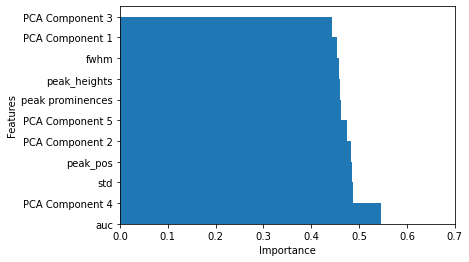

In [22]:
import matplotlib.pyplot as plt
importances = rfr_best_feat.feature_importances_
feat_names = features_matrix.columns

sort_ind = np.argsort(importances)[::-1]
sort_imp = importances[sort_ind]
sort_names = feat_names[sort_ind]

# Plotting feature importances
plt.bar(sort_imp,range(len(sort_imp)))
plt.yticks(range(len(sort_imp)), sort_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.xlim(0, 0.7)
plt.show()

##### Model Blending

In [23]:
# Combining the predictions by averaging them. 
# There are other methods for model blending/stacking but
# for now, let's take the averages.
combined_pred = (y_pred_feat + y_pred_raw) / 2
mse = mean_squared_error(y_test_raw, combined_pred)
print(mse)

0.05553297994371118


##### Plotting Predictions

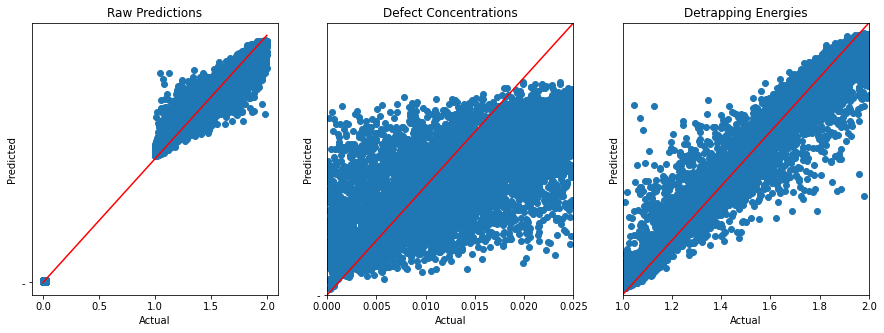

In [53]:
def plot_pred(y_test, y_pred, title):
    y_test = 10 ** y_test
    y_pred = 10 ** y_pred   
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.scatter(y_test, y_pred)
    ax1.plot([0, 2], [0, 2], 'r', '-')
    ax1.set_xlabel('Actual')
    ax1.set_ylabel('Predicted')
    ax1.set_title(title)
    
    ax2.scatter(y_test, y_pred)
    ax2.plot([0, 0.025], [0, 0.025], 'r', '-')
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_xlim(0, 0.025)
    ax2.set_ylim(0, 0.025)
    ax2.set_title('Defect Concentrations')

    ax3.scatter(y_test, y_pred)
    ax3.plot([1, 2], [1, 2], 'r', '-')
    ax3.set_xlabel('Actual')
    ax3.set_ylabel('Predicted')
    ax3.set_title('Detrapping Energies')
    ax3.set_xlim(1, 2)
    ax3.set_ylim(1, 2)

plot_pred(y_test_raw,y_pred_raw, 'Raw Predictions')  

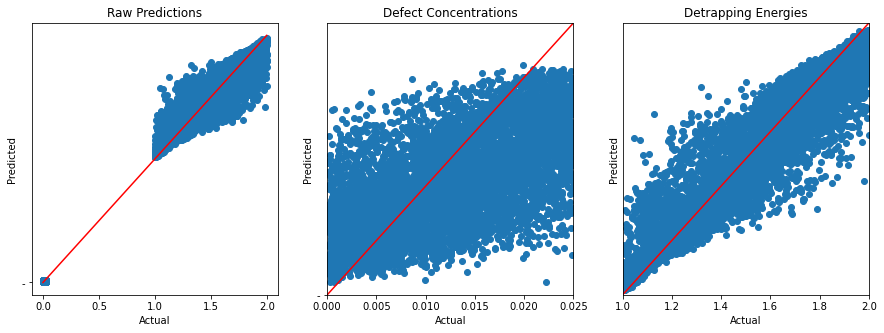

In [54]:
plot_pred(y_test_feat,y_pred_feat, 'Featurized Predictions')  

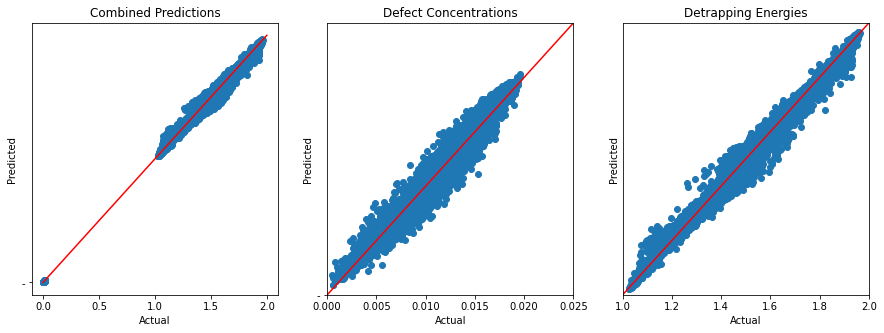

In [55]:
plot_pred(y_pred_raw,combined_pred,'Combined Predictions')

### Predicting Based on the Ground Truth

In [ ]:
#pip install spectrapepper

In [56]:
import spectrapepper as spep
from scipy import signal
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading ground truth data into a dataframe
folder_path = './Ground Truth Smoothed'
data = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path) and file_path.endswith('.csv'):
        with open(file_path, 'r') as file:
            expt_df = pd.read_csv(file_path, header=None, names=['K', 'des_flux'], index_col=None, squeeze = True)
            expt_tds = expt_df.iloc[:, 1].values
            expt_datapts = len(expt_df["des_flux"])
            data[filename] = expt_df    

df = pd.concat(data.values())


expt_des_flux=df['des_flux']
expt_des_flux=expt_des_flux.tolist()
expt_files=int(len(expt_des_flux)/expt_datapts) 
expt_des_flux=np.reshape(expt_des_flux, [expt_files, expt_datapts])

display(len(expt_des_flux[1]))


902

##### GT Raw predictions

In [57]:

expt_pred_raw = []
for i in range(0,14):
    x_expt = np.array(expt_des_flux[i])
    x_expt = x_expt[0::3].reshape(1, -1)

    X_expt_norm = scaler.fit_transform(x_expt)
    X_expt_norm = scaler.transform(X_expt_norm)
    X_test_transform = np.reshape(X_expt_norm, (X_expt_norm.shape[0], -1))

    y_expt_pred = rfr_best_raw.predict(X_test_transform)

    y_expt_pred = np.reshape(y_expt_pred, (8, 1))
    pred_params = pd.DataFrame({'detrap_en':10 ** y_expt_pred[:4,0],
                                'defect_con':10 ** y_expt_pred[4:,0]}) # Inverse log transform

    display(f"Ground Truth {i+1}:", pred_params)
    expt_pred_raw.append(y_expt_pred)
    
    y = x_expt.flatten()
    x = np.linspace(300,1200,301)

    peak_pos = np.argmax(x_expt)
    peak_value = y[peak_pos]
    print(peak_pos, peak_value)
    
    ## Exporting as .csv
    src_path  = r'./log/raw_param/predict_params.csv'
    p = Path(src_path).parent.joinpath(f"raw_pred_params_{i+1}.csv")
    pred_params.to_csv(p, index=False)

'Ground Truth 1:'

,detrap_en,defect_con
0,1.118635,0.002003
1,1.366535,0.001823
2,1.544961,0.001473
3,1.767930,0.001214


152 4.764666666666666e+16


'Ground Truth 2:'

,detrap_en,defect_con
0,1.124941,0.001979
1,1.371263,0.001832
2,1.550385,0.001473
3,1.771399,0.001203


183 4.198666666666667e+17


'Ground Truth 3:'

,detrap_en,defect_con
0,1.116161,0.001956
1,1.364201,0.001738
2,1.546452,0.001429
3,1.767737,0.001260


188 1.684e+17


'Ground Truth 4:'

,detrap_en,defect_con
0,1.120283,0.001947
1,1.366515,0.001818
2,1.545915,0.001485
3,1.767525,0.001208


192 3.017333333333333e+17


'Ground Truth 5:'

,detrap_en,defect_con
0,1.124362,0.002035
1,1.366780,0.001830
2,1.545369,0.001470
3,1.767260,0.001207


194 2.658e+17


'Ground Truth 6:'

,detrap_en,defect_con
0,1.114640,0.002003
1,1.363277,0.001764
2,1.544271,0.001450
3,1.766625,0.001241


183 2.367333333333333e+17


'Ground Truth 7:'

,detrap_en,defect_con
0,1.136385,0.002080
1,1.379246,0.001858
2,1.556473,0.001447
3,1.774871,0.001180


127 6.932e+17


'Ground Truth 8:'

,detrap_en,defect_con
0,1.124905,0.002066
1,1.369454,0.001804
2,1.547300,0.001454
3,1.769280,0.001221


128 3.464666666666667e+17


'Ground Truth 9:'

,detrap_en,defect_con
0,1.119924,0.002021
1,1.368943,0.001765
2,1.547590,0.001411
3,1.769520,0.001191


166 7.518666666666667e+16


'Ground Truth 10:'

,detrap_en,defect_con
0,1.136385,0.002080
1,1.379246,0.001858
2,1.556473,0.001447
3,1.774871,0.001180


195 2.435333333333333e+17


'Ground Truth 11:'

,detrap_en,defect_con
0,1.119144,0.001932
1,1.367646,0.001795
2,1.547052,0.001464
3,1.768443,0.001224


178 1.8546666666666662e+17


'Ground Truth 12:'

,detrap_en,defect_con
0,1.115550,0.001916
1,1.365296,0.001761
2,1.545791,0.001472
3,1.768392,0.001220


127 1.0526666666666666e+18


'Ground Truth 13:'

,detrap_en,defect_con
0,1.121639,0.001961
1,1.371012,0.001797
2,1.549820,0.001461
3,1.770411,0.001193


156 1.124e+17


'Ground Truth 14:'

,detrap_en,defect_con
0,1.132265,0.002068
1,1.375968,0.001805
2,1.555309,0.001444
3,1.774590,0.001190


126 4.756e+17


##### GT Features Predictions

In [58]:
peak_heights = []
fwhm = []
peak_positions = []
area_under_curves = []
stdev = []
peak_prom = []

for i in expt_des_flux:    
# Peak information
# Peak heights, position, prominence, and full width at half max
    peaks, _ = find_peaks(i)
    peak_pos = np.argmax(i)
    peak_height = np.max(i)
    peak_width, _, _, _ = peak_widths(i, [peak_pos], rel_height=0.5) 
    peak_heights.append(peak_height)
    fwhm.append(peak_width[0])
    peak_positions.append(peak_pos)    
    prominence = np.max(peak_prominences(i, peaks)[0])
    peak_prom.append(prominence)

    
# Area under curve
# Calculated using the trapezoidal method
    area_under_curve = auc(range(0,len(i)), i)
    area_under_curves.append(area_under_curve)
# STDEV
    spectra_std = np.std(i)
    stdev.append(spectra_std)
    
pca_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))])

scaled_expt_des = pca_pipe.fit_transform(expt_des_flux)
result_pca = pca_pipe.fit_transform(scaled_expt_des)


# Formatting them into columns in a df
pca_col = ['PCA Component {}'.format(i+1) for i in range(result_pca.shape[1])]
pca_df = pd.DataFrame(data=result_pca, columns=pca_col)

### Making the features matrix 
features_matrix = pd.DataFrame()
features_matrix['peak_heights'] = peak_heights 
features_matrix['peak_pos'] = peak_positions
features_matrix['fwhm'] = fwhm
features_matrix['peak prominences'] = peak_prom
features_matrix['std'] = stdev
features_matrix['auc'] = area_under_curves
features_matrix = pd.concat([features_matrix, pca_df],axis=1)
display(features_matrix)

,peak_heights,peak_pos,fwhm,peak prominences,std,auc,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5
0,4.768667e+16,454,290.162302,4.621400e+16,1.638158e+16,1.514390e+19,0.573820,-1.344016,-0.881941,1.446751,-1.020581
1,4.199333e+17,548,174.494174,4.186840e+17,1.384690e+17,7.686186e+19,-0.808185,2.219939,-0.155072,1.828198,-0.690414
2,1.685333e+17,568,161.047106,1.681642e+17,5.372150e+16,2.813385e+19,0.048297,0.757008,-0.613740,-0.165240,1.941612
3,3.017333e+17,576,202.024550,3.009301e+17,1.001815e+17,6.631249e+19,-1.753257,-0.521085,-0.466775,-1.300463,-1.230600
4,2.658667e+17,581,210.426077,2.651354e+17,8.937861e+16,6.013363e+19,-1.502952,-0.353701,-0.503190,-1.146980,-0.796276
5,2.367333e+17,549,221.706953,2.361737e+17,8.455735e+16,5.292533e+19,-0.902364,0.807566,-0.437093,-0.450549,1.044747
6,6.932000e+17,380,324.911173,6.924385e+17,2.459532e+17,1.972324e+20,0.267411,-0.253964,1.347879,0.043642,-0.150224
7,3.464667e+17,383,313.634003,3.456960e+17,1.257978e+17,9.758620e+19,0.020229,0.049100,0.039784,0.697489,0.600036
8,7.526667e+16,497,209.625626,7.475715e+16,2.516947e+16,1.604650e+19,0.751804,-0.742939,-0.812088,-0.975589,1.652628
9,2.436000e+17,586,257.656037,2.427514e+17,8.226860e+16,5.808884e+19,2.318502,1.625712,-0.210846,-1.580642,-1.445715


In [59]:
# Predicting based on features and combining predictions
scaler.fit(X_train)
norm_feat_mat = scaler.transform(features_matrix)
expt_pred_feat = rfr_best_feat.predict(norm_feat_mat)
expt_pred_raw = np.array(expt_pred_raw).reshape(14,8)

combined_expt_pred = ( expt_pred_feat + expt_pred_raw ) / 2

In [60]:
# Exporting
for num, i in enumerate(expt_pred_feat):
    pred_params = pd.DataFrame({'detrap_en':10 ** i[:4],
                                'defect_con':10 ** i[4:]}) # Inverse log transform

    src_path  = r'./log/feat_param/predict_params.csv'
    p = Path(src_path).parent.joinpath(f"feat_pred_params_{num+1}.csv")
    pred_params.to_csv(p, index=False)


for num, i in enumerate(combined_expt_pred):
    pred_params = pd.DataFrame({'detrap_en':10 ** i[:4],
                                'defect_con':10 ** i[4:]}) # Inverse log transform

    src_path  = r'./log/combined/predict_params.csv'
    p = Path(src_path).parent.joinpath(f"combined_pred_params_{num+1}.csv")
    pred_params.to_csv(p, index=False)
    